In [ ]:
!pip install emoji
!pip install tweet-preprocessor
!pip install nltk
!pip install sentencepiece
!pip install keras
!pip install tensorflow
!pip install keras-self-attention


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=12be6cd7ac06daaa0ea895759e9034fb76f37e55af4ae3fc47c232b77b691b94
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import preprocessor as p
import re
import random



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Load the dataset
file_path = '/content/FA-KES-Dataset.csv'
data = pd.read_csv(file_path,encoding="Latin-1")

# Define the random deletion function
def random_deletion(text, p=0.1):
    # Split the text into words
    words = text.split()
    # Calculate the number of words to delete
    num_words_to_delete = max(1, int(len(words) * p))
    # Randomly select words to delete
    words_to_delete = random.sample(words, num_words_to_delete)
    # Remove the selected words from the text
    augmented_text = ' '.join([word for word in words if word not in words_to_delete])
    return augmented_text

# Apply data augmentation to create augmented samples
augmented_samples = []
for text in data['article_content']:
    augmented_text = random_deletion(text)
    augmented_samples.append(augmented_text)

# Add augmented samples to the original dataset
augmented_data = pd.DataFrame({'article_content': augmented_samples, 'labels': data['labels']})

# Concatenate the original and augmented datasets
augmented_data = pd.concat([data, augmented_data], ignore_index=True)

# Shuffle the dataset
augmented_data = augmented_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Preprocess the text data
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Use tweet-preprocessor to remove URLs, mentions, hashtags, and emojis
    text = p.clean(text)

    # Remove punctuation except for numbers
    text = re.sub(r'[^\w\s\d]|_', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text

# Applying text preprocessing to the "tweet" column in both data and val_data
data['article_content'] = data['article_content'].apply(preprocess_text)

print("Preprocessed Data:")
print(data.head())

data['article_content'] = data['article_content'].apply(preprocess_text)

# Separate features and labels
X = data['article_content']
y = data['labels']

Preprocessed Data:
      unit_id                                      article_title  \
0  1914947530  Syria attack symptoms consistent with nerve ag...   
1  1914947532  Homs governor says U.S. attack caused deaths b...   
2  1914947533    Death toll from Aleppo bomb attack at least 112   
3  1914947534        Aleppo bomb blast kills six Syrian state TV   
4  1914947535  29 Syria Rebels Dead in Fighting for Key Alepp...   

                                     article_content source       date  \
0  wed apr syria attack symptom consistent nerve ...    nna   4/5/2017   
1  fri apr homs governor say u attack caused deat...    nna   4/7/2017   
2  sun apr death toll aleppo bomb attack least de...    nna  4/16/2017   
3  wed apr aleppo bomb blast kill six syrian stat...    nna  4/19/2017   
4  sun jul syria rebel dead fighting key aleppo r...    nna  7/10/2016   

  location  labels  Unnamed: 7  Unnamed: 8  Unnamed: 9 Unnamed: 10  
0    idlib       0         NaN         NaN         NaN    

In [ ]:
# Tokenize and pad sequences
max_words = 10000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=maxlen)

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

Epoch 1/50
21/21 [==============================] - 8s 117ms/step - loss: 0.6982 - accuracy: 0.4619 - val_loss: 0.6917 - val_accuracy: 0.5466
Epoch 2/50
21/21 [==============================] - 2s 83ms/step - loss: 0.6566 - accuracy: 0.9176 - val_loss: 0.6916 - val_accuracy: 0.5342
Epoch 3/50
21/21 [==============================] - 2s 82ms/step - loss: 0.6280 - accuracy: 0.8523 - val_loss: 0.6900 - val_accuracy: 0.5155
Epoch 4/50
21/21 [==============================] - 2s 80ms/step - loss: 0.5959 - accuracy: 0.9207 - val_loss: 0.6907 - val_accuracy: 0.5342
Epoch 5/50
21/21 [==============================] - 2s 82ms/step - loss: 0.5579 - accuracy: 0.9487 - val_loss: 0.6923 - val_accuracy: 0.6149
Epoch 6/50
21/21 [==============================] - 2s 83ms/step - loss: 0.5093 - accuracy: 0.9430 - val_loss: 0.6901 - val_accuracy: 0.5714
Epoch 7/50
21/21 [==============================] - 3s 127ms/step - loss: 0.4484 - accuracy: 0.9616 - val_loss: 0.6920 - val_accuracy: 0.6190
Epoch 8/50


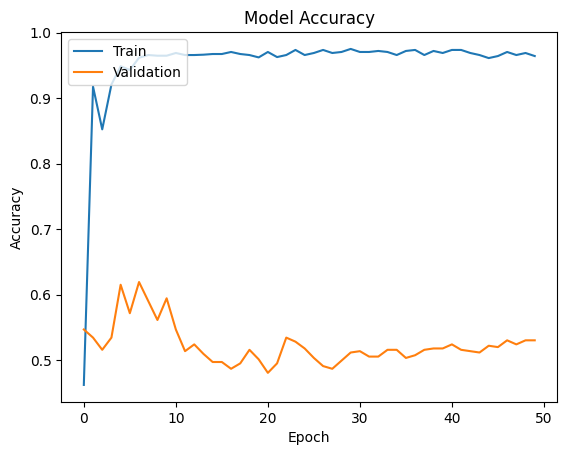

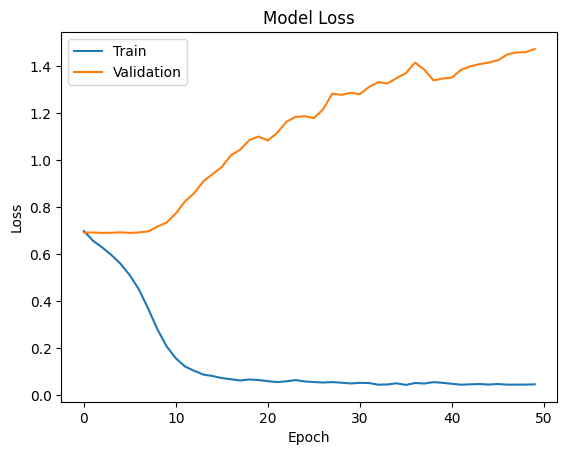

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
import matplotlib.pyplot as plt

# Define model architecture
embedding_dim = 128
num_filters = 64
kernel_sizes = [3, 4, 5]

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen)(inputs)
conv_layers = []
for kernel_size in kernel_sizes:
    conv_layer = Conv1D(num_filters, kernel_size, activation='relu')(embedding_layer)
    maxpool_layer = MaxPooling1D(pool_size=maxlen - kernel_size + 1)(conv_layer)
    conv_layers.append(maxpool_layer)

concatenated_tensor = Concatenate(axis=1)(conv_layers)
attention_output = SeqSelfAttention(attention_activation='sigmoid')(concatenated_tensor)  
outputs = Dense(1, activation='sigmoid')(attention_output)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", accuracy)

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [ ]:
import numpy as np

# true labels and predicted probabilities from your dataset
true_labels = y_val  
predicted_probabilities = model.predict(X_val)  

# Threshold the predicted probabilities to obtain binary predictions
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Flatten the predicted labels array
predicted_labels_flattened = predicted_labels.flatten()

# Reshape the predicted labels array to match the shape of the true labels array
predicted_labels_reshaped = predicted_labels_flattened[:len(true_labels)]

# Compute true positives, false positives, false negatives
tp = np.sum((true_labels == 1) & (predicted_labels_reshaped == 1))
fp = np.sum((true_labels == 0) & (predicted_labels_reshaped == 1))
fn = np.sum((true_labels == 1) & (predicted_labels_reshaped == 0))

# Compute precision, recall, and F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


6/6 [==============================] - 0s 21ms/step
Precision: 0.6666666666666666
Recall: 0.4044943820224719
F1 Score: 0.5034965034965035
